# 1. 환경설정

- 파이토치
- 한국어를 영어로 번역하는 Seq2Seq(기본 모델, Attention 적용 모델)을 구현
- JSON 파일(train_set.json, valid_set.json) 형식
- 데이터셋 각 항목은 한국어 문장("ko")과 영어 번역문("mt")으로 구성
- 적절한 토크나이저를 선택하여 한국어, 영어 문장을 토큰화
- 필요한 경우 SOS, EOS, PAD, UNK 등의 특수 토큰을 정의
- 한국어와 영어 각각의 어휘 사전 구성
- Seq2Seq 모델: GRU 기반의 Encoder-Decoder 모델을 구현하고, Teacher Forcing 기법을 적용해 학습
- Attention 모델: Attention(Bahdanau 혹은 Luong)을 적용한 디코더를 구현
- 무작위 문장 쌍에 대해 모델의 번역 결과를 출력
- 다양한 평가 지표(예: BLEU 점수) 도입

In [ ]:
""" 디렉토리 설정 """
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive; drive.mount('/content/drive')
    import drive.MyDrive.develop.config_my_path as cc
    cc.dir('projects/side/250625-250702_machine-translator/machine-translator')


""" 라이브러리 설정 """
# 시스템 & 유틸
import os
import json
import random
import numpy as np
from tqdm import tqdm
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 전처리
!pip install kiwipiepy
!pip install konlpy
from kiwipiepy import Kiwi
from konlpy.tag import Mecab
import spacy
from collections import Counter

# BLEU
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from kiwipiepy import Kiwi
import spacy
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import random # Seq2Seq 모델에서 사용하므로 추가


# 디바이스
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive
/content/drive/MyDrive/develop/projects/side/250625-250702_machine-translator/machine-translator
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 71.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 132.4 MB/s eta 0:00:00
  Created wheel for kiwipiepy_model: filename=kiwipiepy_model-0.21.0-py3-none-any.whl size=35593192 sha256=ced425f96a3ee214e6f52fea9082075fb449fbb2c2ac9c61554f66155abdf507
  Stored in directory: /root/.cache/pip/wheels/b0/16/3d/95053ab5298f0f0f22ffea6de0200b6f24bffb73cab4c1a828
Successfully built kiwipiepy_model
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 36.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 2. EDA

Train datas: 1200000
Valid datas: 150000
----------------
KO: 원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.
MT: If you reply to the color you want, we will start making it right away.
----------------
Train set
KO Avg Length: 27
EN Avg Length: 54
KO Max Length: 297
EN Max Length: 377
----------------
Valid set
KO Avg Length: 27
EN Avg Length: 54
KO Max Length: 282
EN Max Length: 295
----------------


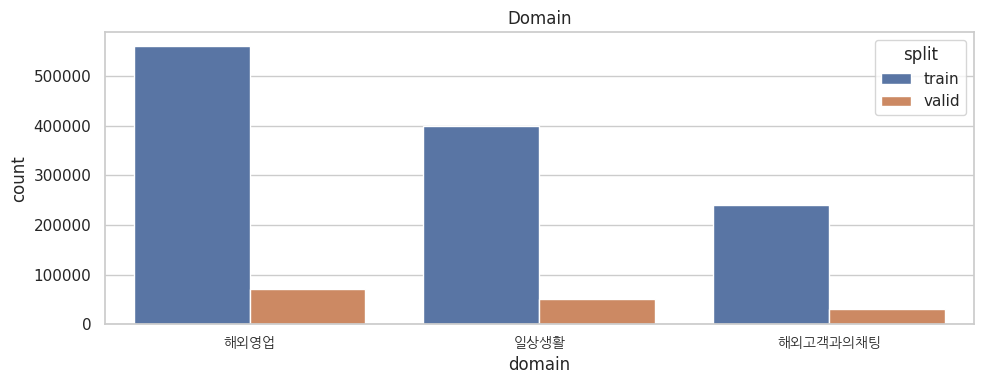

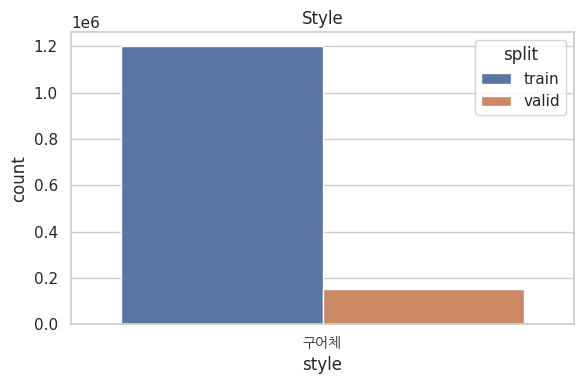

In [ ]:
# JSON 기본 정보 확인
def load_json_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data['data']

train_path = 'train_set.json'
valid_path = 'valid_set.json'

train_data = load_json_data(train_path)
valid_data = load_json_data(valid_path)

print(f"Train datas: {len(train_data)}")
print(f"Valid datas: {len(valid_data)}")
print("----------------")
print("KO:", train_data[0]['ko'])
print("MT:", train_data[0]['mt'])
print("----------------")
train_data[0]


# 문장 길이 측정
def get_sentence_lengths(data):
    ko_lens = [len(item['ko']) for item in data]
    en_lens = [len(item['mt']) for item in data]
    return ko_lens, en_lens

ko_lengths_train, en_lengths_train = get_sentence_lengths(train_data)
print("Train set")
print(f"KO Avg Length: {np.mean(ko_lengths_train):.0f}")
print(f"EN Avg Length: {np.mean(en_lengths_train):.0f}")
print(f"KO Max Length: {max(ko_lengths_train)}")
print(f"EN Max Length: {max(en_lengths_train)}")
print("----------------")

ko_lengths_valid, en_lengths_valid = get_sentence_lengths(valid_data)
print("Valid set")
print(f"KO Avg Length: {np.mean(ko_lengths_valid):.0f}")
print(f"EN Avg Length: {np.mean(en_lengths_valid):.0f}")
print(f"KO Max Length: {max(ko_lengths_valid)}")
print(f"EN Max Length: {max(en_lengths_valid)}")
print("----------------")

# 폰트 등록
font_path = "NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
font_name = fontprop.get_name()

# JSON 데이터 로딩
with open('train_set.json', encoding='utf-8') as f:
    train_data = json.load(f)['data']
with open('valid_set.json', encoding='utf-8') as f:
    valid_data = json.load(f)['data']

train_df = pd.DataFrame(train_data)
train_df['split'] = 'train'
valid_df = pd.DataFrame(valid_data)
valid_df['split'] = 'valid'

df = pd.concat([train_df, valid_df], ignore_index=True)

sns.set(style="whitegrid")

# domain 분포
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='domain', hue='split', order=df['domain'].value_counts().index)
plt.title('Domain')
plt.xticks(fontproperties=fontprop)
plt.tight_layout()
plt.show()

# style 분포
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='style', hue='split', order=df['style'].value_counts().index)
plt.title('Style')
plt.xticks(fontproperties=fontprop)
plt.tight_layout()
plt.show()

# 3. 전처리

In [ ]:
!ls -al

total 1207822
drwx------ 2 root root      4096 Jun 25 04:44 .git
-rw------- 1 root root      4512 Jun 25 04:44 .gitignore
-rw------- 1 root root     14545 Jun 26 01:48 mt001.ipynb
-rw------- 1 root root     92521 Jun 27 16:10 mt002.ipynb
-rw------- 1 root root    106711 Jun 28 10:12 mt003.ipynb
-rw------- 1 root root     89592 Jun 28 13:08 mt004.ipynb
-rw------- 1 root root   4691820 Jun 27 01:42 NanumGothic.ttf
-rw------- 1 root root        20 Jun 25 04:44 README.md
-rw------- 1 root root 121084928 Jun 28 12:55 tokenized_train.pt
-rw------- 1 root root  16538496 Jun 28 13:08 tokenized_valid.pt
-rw------- 1 root root 972643210 Jun 26 00:05 train_set.json
-rw------- 1 root root 121536888 Jun 26 00:05 valid_set.json


In [ ]:
import os
import json
import random
import torch
from collections import Counter
from pathlib import Path
from tqdm import tqdm
from kiwipiepy import Kiwi
import spacy
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# ----------------------------
# 설정
# ----------------------------
SPECIAL_TOKENS = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
TRAIN_JSON   = "train_set.json"
VALID_JSON   = "valid_set.json"
TRAIN_CACHE  = "tokenized_train.pt"
VALID_CACHE  = "tokenized_valid.pt"
SMOKE_RATIO  = 1.0     # 0<ratio<1: 비율, 1.0: 전체 데이터
MIN_FREQ     = 2
BATCH_SIZE   = 64

# ----------------------------
# 토크나이저
# ----------------------------
class Tokenizer:
    def __init__(self):
        self.kiwi = Kiwi()
        self.en   = spacy.load("en_core_web_sm")
    def tokenize_ko(self, text):
        return [t.form for t in self.kiwi.tokenize(text)]
    def tokenize_en(self, text):
        return [t.text.lower() for t in self.en(text)]

# ----------------------------
# vocab 생성
# ----------------------------
def build_vocab(tokenized_sents, min_freq=MIN_FREQ):
    ctr    = Counter(tok for sent in tokenized_sents for tok in sent)
    tokens = [tok for tok, f in ctr.items() if f >= min_freq]
    vocab  = {tok: idx for idx, tok in enumerate(tokens, start=len(SPECIAL_TOKENS))}
    return {**SPECIAL_TOKENS, **vocab}

# ----------------------------
# 토큰 → ID
# ----------------------------
def encode(tokens, vocab, add_sos_eos=True):
    ids = [vocab.get(t, SPECIAL_TOKENS["<unk>"]) for t in tokens]
    if add_sos_eos:
        return [SPECIAL_TOKENS["<sos>"]] + ids + [SPECIAL_TOKENS["<eos>"]]
    return ids

# ----------------------------
# collate_fn
# ----------------------------
def collate_fn(batch):
    ko_batch, en_batch = zip(*batch)
    ko_pad = pad_sequence(ko_batch, batch_first=True, padding_value=SPECIAL_TOKENS["<pad>"])
    en_pad = pad_sequence(en_batch, batch_first=True, padding_value=SPECIAL_TOKENS["<pad>"])
    return ko_pad, en_pad

# ----------------------------
# Dataset
# ----------------------------
class IndexedDataset(Dataset):
    def __init__(self, indexed):
        self.indexed = indexed
    def __len__(self):
        return len(self.indexed)
    def __getitem__(self, idx):
        item = self.indexed[idx]
        return torch.tensor(item["ko"]), torch.tensor(item["mt"])

# ----------------------------
# 전처리 및 캐시
# ----------------------------
def process_split(json_path, cache_path, tokenizer, ratio, ko_vocab=None, en_vocab=None, build_vocab_flag=False):
    if os.path.exists(cache_path):
        print(f"[SKIP] '{cache_path}' already exists.")
        return torch.load(cache_path)

    data = json.load(open(json_path, "r", encoding="utf-8"))["data"]
    if 0 < ratio < 1:
        random.seed(42)
        data = random.sample(data, int(len(data) * ratio))

    ko_sents = [d["ko"] for d in data]
    en_sents = [d["mt"] for d in data]

    ko_tok = [tokenizer.tokenize_ko(s) for s in tqdm(ko_sents, desc=f"Tokenizing KO ({Path(json_path).name})")]
    en_tok = [tokenizer.tokenize_en(s) for s in tqdm(en_sents, desc=f"Tokenizing EN ({Path(json_path).name})")]

    if build_vocab_flag:
        ko_vocab = build_vocab(ko_tok)
        en_vocab = build_vocab(en_tok)

    indexed = []
    for ks, es in tqdm(zip(ko_tok, en_tok), total=len(ko_tok), desc=f"Encoding ({Path(json_path).name})"):
        indexed.append({"ko": encode(ks, ko_vocab), "mt": encode(es, en_vocab)})

    torch.save((indexed, ko_vocab, en_vocab), cache_path)
    print(f"[SAVED] '{cache_path}'")
    return indexed, ko_vocab, en_vocab

# ----------------------------
# 실행
# ----------------------------
tokenizer = Tokenizer()

# Train: vocab 생성 포함
train_indexed, ko_vocab, en_vocab = process_split(
    TRAIN_JSON, TRAIN_CACHE, tokenizer,
    ratio=SMOKE_RATIO, build_vocab_flag=True
)

# Valid: 기존 vocab 재사용
valid_indexed, _, _ = process_split(
    VALID_JSON, VALID_CACHE, tokenizer,
    ratio=SMOKE_RATIO, ko_vocab=ko_vocab, en_vocab=en_vocab, build_vocab_flag=False
)

# DataLoader 준비
train_loader = DataLoader(IndexedDataset(train_indexed), batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(IndexedDataset(valid_indexed), batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=collate_fn)

print(f"✅ train batches: {len(train_loader)}, valid batches: {len(valid_loader)}")


[SKIP] 'tokenized_train.pt' already exists.
[SKIP] 'tokenized_valid.pt' already exists.
✅ train batches: 18750, valid batches: 2344


# 4. 모델 구현

## GRU 기반 Seq2Seq

In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        emb_con = torch.cat((embedded, context.unsqueeze(0)), dim=2)
        output, hidden = self.rnn(emb_con, hidden)
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context[-1])
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

## GRU 기반 Seq2Seq with Bahdanau Attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttnEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

class AttnDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0)

class AttnSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

## 모델 인스턴스 생성

In [ ]:
import torch
import torch.nn as nn


# 1. 하이퍼파라미터 및 환경 설정
# 단어장 크기는 전처리 단계에서 생성된 vocab 객체로부터 가져옴
INPUT_DIM = len(ko_vocab)
OUTPUT_DIM = len(en_vocab)

# 모델의 각 부분 차원 정의
ENC_EMB_DIM = 256   # 인코더 임베딩 차원
DEC_EMB_DIM = 256   # 디코더 임베딩 차원
HID_DIM = 512       # 기본 모델의 GRU 히든 차원
ENC_HID_DIM = 512   # 어텐션 모델 인코더의 GRU 히든 차원
DEC_HID_DIM = 512   # 어텐션 모델 디코더의 GRU 히든 차원
N_LAYERS = 2        # 기본 모델의 GRU 레이어 수
DROPOUT = 0.5

print("--- Hyperparameter & Environment Setup ---")
print(f"device: {device}")
print(f"Korean Vocab Size (Input Dim): {INPUT_DIM}")
print(f"English Vocab Size (Output Dim): {OUTPUT_DIM}")


# =================================================================================
# 2. 모델 객체 생성
# =================================================================================

# --- 2-1. 기본 Seq2Seq 모델 객체 생성 ---
print("\n--- Creating Model 1: Basic Seq2Seq ---")
basic_encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
basic_decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model_basic = Seq2Seq(basic_encoder, basic_decoder, device).to(device)


# --- 2-2. 어텐션 Seq2Seq 모델 객체 생성 ---
print("--- Creating Model 2: Attention Seq2Seq ---")
attn_encoder = AttnEncoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DROPOUT)
attention = BahdanauAttention(ENC_HID_DIM, DEC_HID_DIM)
attn_decoder = AttnDecoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DROPOUT, attention)
model_attn = AttnSeq2Seq(attn_encoder, attn_decoder, device).to(device)


# =================================================================================
# 3. 모델 파라미터 수 확인
# =================================================================================

def count_parameters(model):
    """모델의 학습 가능한 파라미터 수를 계산하는 함수"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n--- Parameter Counts ---")
print(f"The Basic Seq2Seq model has {count_parameters(model_basic):,} trainable parameters.")
print(f"The Attention Seq2Seq model has {count_parameters(model_attn):,} trainable parameters.")


--- Hyperparameter & Environment Setup ---
device: cuda
Korean Vocab Size (Input Dim): 42419
English Vocab Size (Output Dim): 36593

--- Creating Model 1: Basic Seq2Seq ---
--- Creating Model 2: Attention Seq2Seq ---

--- Parameter Counts ---
The Basic Seq2Seq model has 45,303,025 trainable parameters.
The Attention Seq2Seq model has 92,271,601 trainable parameters.


# 5. 모델 훈련

In [ ]:
# --- [2차 검문] 훈련 시작 직전 상태 ---

print("\n\n--- 🕵️ 2차 검문: 훈련 시작 직전 상태 🕵️ ---")

# 1. 훈련에 사용될 단어장의 크기
vocab_size_before_train = len(ko_vocab)
print(f"훈련 직전 메모리의 단어장(ko_vocab) 크기: {vocab_size_before_train}")

# 2. 실제 모델에 설정된 임베딩 레이어의 크기
model_input_dim = model_basic.encoder.embedding.num_embeddings
print(f"실제 모델(model_basic)에 설정된 Embedding 크기: {model_input_dim}")

# 3. train_loader가 담고 있는 데이터의 인덱스 최댓값
first_batch_src, _ = next(iter(train_loader))
max_index_in_batch = first_batch_src.max().item()
print(f"데이터로더(train_loader)의 첫 배치 최대 인덱스: {max_index_in_batch}")

# 4. 최종 충돌 확인
print("\n--- 최종 점검 ---")
if model_input_dim <= max_index_in_batch:
    print(f"❌ 범인 확정! 데이터 속 인덱스({max_index_in_batch})가 모델의 한계({model_input_dim})를 벗어났습니다.")
    print("이것은 'train_loader'와 'model_basic'이 서로 다른 단어장 기준으로 만들어졌다는 확실한 증거입니다.")
else:
    print("✅ 2차 검문 통과: 모델과 데이터가 완벽히 일치합니다. 에러가 날 수 없는 상태입니다.")



--- 🕵️ 2차 검문: 훈련 시작 직전 상태 🕵️ ---
훈련 직전 메모리의 단어장(ko_vocab) 크기: 42419
실제 모델(model_basic)에 설정된 Embedding 크기: 42419
데이터로더(train_loader)의 첫 배치 최대 인덱스: 32503

--- 최종 점검 ---
✅ 2차 검문 통과: 모델과 데이터가 완벽히 일치합니다. 에러가 날 수 없는 상태입니다.


In [ ]:
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import math # Perplexity 계산을 위해 추가


opt_basic = optim.Adam(model_basic.parameters(), lr=0.0005)
criterion_basic = nn.CrossEntropyLoss(ignore_index=SPECIAL_TOKENS['<pad>'])

opt_attn = optim.Adam(model_attn.parameters(), lr=0.0005)
criterion_attn = nn.CrossEntropyLoss(ignore_index=SPECIAL_TOKENS['<pad>'])


def train_model(model, train_loader, valid_loader, optimizer, criterion, epochs, device, clip=1.0):

    model_name = model.__class__.__name__
    best_valid_loss = float('inf')

    print(f"\n========== Starting Training & Evaluation for: {model_name} ==========")

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        print(f"\n--- Epoch {epoch+1}/{epochs} ---")

        for i, (src, trg) in enumerate(tqdm(train_loader, desc="Training")):
            src, trg = src.to(device).T, trg.to(device).T
            optimizer.zero_grad()
            output = model(src, trg, teacher_forcing_ratio=0.5)

            output_dim = output.shape[-1]

            output_reshaped = output[1:].reshape(-1, output_dim)
            trg_reshaped = trg[1:].reshape(-1)
            # --------------------

            loss = criterion(output_reshaped, trg_reshaped)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for i, (src, trg) in enumerate(tqdm(valid_loader, desc="Evaluating")):
                src, trg = src.to(device).T, trg.to(device).T
                output = model(src, trg, 0)

                output_dim = output.shape[-1]

                output_reshaped = output[1:].reshape(-1, output_dim)
                trg_reshaped = trg[1:].reshape(-1)
                # --------------------

                loss = criterion(output_reshaped, trg_reshaped)
                total_valid_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_valid_loss = total_valid_loss / len(valid_loader)

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {avg_train_loss:.3f} | Train PPL: {math.exp(avg_train_loss):7.3f}')
        print(f'\t Val. Loss: {avg_valid_loss:.3f} |  Val. PPL: {math.exp(avg_valid_loss):7.3f}')

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), f'best-model-{model_name}.pth')
            print(f"✅ Best model saved with validation loss: {best_valid_loss:.4f}")



# 하이퍼파라미터
epochs = 10
clip = 1.0

# Basic 모델 훈련
train_model(model_basic, train_loader, valid_loader, opt_basic, criterion_basic, epochs, device, clip=clip)

# Attention 모델 훈련
train_model(model_attn, train_loader, valid_loader, opt_attn, criterion_attn, epochs, device, clip=clip)


========== Starting Training & Evaluation for: Seq2Seq ==========

--- Epoch 1/10 ---


Evaluating: 100%|██████████| 2344/2344 [05:19<00:00,  7.33it/s]


Epoch: 01
	Train Loss: 4.161 | Train PPL:  64.105
	 Val. Loss: 4.353 |  Val. PPL:  77.736
✅ Best model saved with validation loss: 4.3533

--- Epoch 2/10 ---


Evaluating: 100%|██████████| 2344/2344 [05:20<00:00,  7.31it/s]


Epoch: 02
	Train Loss: 3.438 | Train PPL:  31.127
	 Val. Loss: 4.060 |  Val. PPL:  57.981
✅ Best model saved with validation loss: 4.0601

--- Epoch 3/10 ---


Evaluating: 100%|██████████| 2344/2344 [05:19<00:00,  7.33it/s]


Epoch: 03
	Train Loss: 3.178 | Train PPL:  24.011
	 Val. Loss: 3.944 |  Val. PPL:  51.637
✅ Best model saved with validation loss: 3.9442

--- Epoch 4/10 ---


Evaluating: 100%|██████████| 2344/2344 [05:26<00:00,  7.17it/s]


Epoch: 04
	Train Loss: 3.021 | Train PPL:  20.522
	 Val. Loss: 3.874 |  Val. PPL:  48.130
✅ Best model saved with validation loss: 3.8739

--- Epoch 5/10 ---


Evaluating: 100%|██████████| 2344/2344 [05:16<00:00,  7.40it/s]


Epoch: 05
	Train Loss: 2.908 | Train PPL:  18.317
	 Val. Loss: 3.814 |  Val. PPL:  45.350
✅ Best model saved with validation loss: 3.8144

--- Epoch 6/10 ---


Evaluating: 100%|██████████| 2344/2344 [05:24<00:00,  7.23it/s]


Epoch: 06
	Train Loss: 2.823 | Train PPL:  16.819
	 Val. Loss: 3.780 |  Val. PPL:  43.824
✅ Best model saved with validation loss: 3.7802

--- Epoch 7/10 ---


Evaluating: 100%|██████████| 2344/2344 [05:23<00:00,  7.25it/s]


Epoch: 07
	Train Loss: 2.754 | Train PPL:  15.708
	 Val. Loss: 3.760 |  Val. PPL:  42.965
✅ Best model saved with validation loss: 3.7604

--- Epoch 8/10 ---


Evaluating: 100%|██████████| 2344/2344 [05:19<00:00,  7.33it/s]


Epoch: 08
	Train Loss: 2.698 | Train PPL:  14.852
	 Val. Loss: 3.739 |  Val. PPL:  42.041
✅ Best model saved with validation loss: 3.7386

--- Epoch 9/10 ---


Evaluating: 100%|██████████| 2344/2344 [05:21<00:00,  7.30it/s]


Epoch: 09
	Train Loss: 2.650 | Train PPL:  14.151
	 Val. Loss: 3.730 |  Val. PPL:  41.696
✅ Best model saved with validation loss: 3.7304

--- Epoch 10/10 ---


Evaluating: 100%|██████████| 2344/2344 [05:15<00:00,  7.42it/s]


Epoch: 10
	Train Loss: 2.610 | Train PPL:  13.599
	 Val. Loss: 3.713 |  Val. PPL:  40.970
✅ Best model saved with validation loss: 3.7128

========== Starting Training & Evaluation for: AttnSeq2Seq ==========

--- Epoch 1/10 ---


Evaluating: 100%|██████████| 2344/2344 [06:06<00:00,  6.40it/s]


Epoch: 01
	Train Loss: 3.445 | Train PPL:  31.339
	 Val. Loss: 3.831 |  Val. PPL:  46.112
✅ Best model saved with validation loss: 3.8311

--- Epoch 2/10 ---


Training:  52%|█████▏    | 9782/18750 [43:25<43:29,  3.44it/s]

# 6. 모델 평가

In [ ]:
import os
import json
import random
import torch
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from types import MethodType

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EVAL_RATIO = 0.01  # 평가 비율

# -----------------------------------------------------------------------------
# 1) Attention.forward 패치 함수
# -----------------------------------------------------------------------------
def patched_attention_forward(self, hidden, encoder_outputs):
    # hidden: Tensor [num_layers * num_directions, batch, hidden_size]
    # encoder_outputs: [src_len, batch, hidden_size]
    # 1) 마지막 레이어만 사용
    if hidden.dim() == 3:
        # bidirectional 이면 num_directions=2 이므로 마지막 레이어는 -1 인덱스가 아니라
        # torch.split 방식으로 레이어 단위로 접근해야 할 수 있으나,
        # 간단히 hidden[-1] 로도 충분합니다.
        h = hidden[-1]
    else:
        h = hidden  # 이미 [batch, hidden_size]

    src_len = encoder_outputs.shape[0]
    # 2) [batch, 1, hid] → [batch, src_len, hid]
    h = h.unsqueeze(1).repeat(1, src_len, 1)
    # 3) encoder_outputs: [src_len, batch, hid] → [batch, src_len, hid]
    enc = encoder_outputs.permute(1, 0, 2)
    # 4) energy 계산
    energy = torch.tanh(self.attn(torch.cat((h, enc), dim=2)))
    # 5) attention score 반환
    return energy.sum(dim=2)

# -----------------------------------------------------------------------------
# 2) translate_sentence / BLEU 계산 (샘플링 포함)
# -----------------------------------------------------------------------------
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()
    tokens = tokenizer.tokenize_ko(sentence) if isinstance(sentence, str) else list(sentence)
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_idx = [src_vocab.get(t, src_vocab['<unk>']) for t in tokens]
    src_tensor = torch.LongTensor(src_idx).unsqueeze(1).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    # 디코더에 넘어가는 hidden 은 그대로 두고,
    # model.decoder.attention 에는 patched 함수가 적용되어 있습니다.

    trg_idx = [trg_vocab['<sos>']]
    inv_trg = {v: k for k, v in trg_vocab.items()}

    for _ in range(max_len):
        trg_tensor = torch.LongTensor([trg_idx[-1]]).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)
        pred = output.argmax(1).item()
        trg_idx.append(pred)
        if pred == trg_vocab['<eos>']:
            break

    return [inv_trg[i] for i in trg_idx[1:-1]]

def calculate_bleu(raw_data, model, device):
    list_of_refs, hyps = [], []
    for datum in tqdm(raw_data, desc=f"BLEU {model.__class__.__name__}"):
        src, tgt = datum['ko'], datum['mt']
        ref_tok = tokenizer.tokenize_en(tgt)
        hyp_tok = translate_sentence(src, ko_vocab, en_vocab, model, device)
        list_of_refs.append([ref_tok])
        hyps.append(hyp_tok)
    return corpus_bleu(list_of_refs, hyps,
                       smoothing_function=SmoothingFunction().method4)

# -----------------------------------------------------------------------------
# 3) 메인: 데이터 로드, 샘플링, 모델 로드, BLEU 평가
# -----------------------------------------------------------------------------
# (1) 검증 데이터
with open('valid_set.json', 'r', encoding='utf-8') as f:
    valid_raw = json.load(f)['data']
if 0 < EVAL_RATIO < 1:
    random.seed(42)
    valid_raw = random.sample(valid_raw, int(len(valid_raw) * EVAL_RATIO))
print(f"Evaluating on {len(valid_raw)} examples ({EVAL_RATIO*100:.2f}% of validation set)")

# (2) 모델 리스트
models_to_eval = [
    (model_basic, 'best-model-Seq2Seq.pth'),
    (model_attn,  'best-model-AttnSeq2Seq.pth'),
]

for model, path in models_to_eval:
    if not os.path.exists(path):
        print(f"❌ 모델 파일 없음: {path}")
        continue

    # (3) Attention 모듈만 런타임에 패치
    model.decoder.attention.forward = MethodType(patched_attention_forward, model.decoder.attention)

    # (4) 모델 불러오기
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)

    # (5) BLEU 평가
    bleu = calculate_bleu(valid_raw, model, device)
    print(f"✅ {model.__class__.__name__} BLEU: {bleu*100:.2f}")
